In [37]:
import os
import sys
import pandas as pd
pd.set_option("mode.copy_on_write", True)

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning


jobs = cleaning.prep(pd.read_pickle("../data/jobs.pkl"), filtered=False, categories_reduced=False)
# jobs.head()

In [38]:
jobs = jobs[
	(jobs["Description"] != "Nicht stepstone") & 
	(jobs["Description"] != "Stellenanzeige nicht mehr verfügbar") & 
	(jobs["Description"] != "")]
descriptions_profile = jobs["Description"] + jobs["Profile"]

In [39]:
import nltk
import re
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from HanTa import HanoverTagger as ht
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
def tokenize_doc(doc):
	stopwords_ger = stopwords.words("german")
	stopwords_ger.extend(["du", "sie"])
	stopwords_en = stopwords.words("english")
	
	cleaned = re.sub(r"[\W](?=\w)", " ", 
				doc.replace("\u200b", " ")
				.replace("\xad", "")
				.replace("-", " ")
				.replace("/", " ")
				.replace("·", " ")
				.replace("•", " ")
				.replace("…", " ")
				)
	tokenized = word_tokenize(cleaned, language="german")
	alphas = [w.lower() for w in tokenized if w.isalpha()]
	
	tagger = ht.HanoverTagger('morphmodel_ger.pgz')
	
	no_stops_de = [w for w in alphas if w not in stopwords_ger]
	no_stops_de_en = [w for w in no_stops_de if w not in stopwords_en]
	
	lemmatized = [tagger.analyze(token)[0].lower() for token in no_stops_de_en]

	return lemmatized

if os.path.isfile("../data/lemmatized_docs.pkl"):
	with open("../data/lemmatized_docs.pkl", "rb") as file:
		old_lemmas = pickle.load(file)
else:
	old_lemmas = []

# old_lemmas = []

docs = [doc for doc in descriptions_profile]

if len(docs) > len(old_lemmas):
	new_docs = docs[len(old_lemmas):]
	docs_count = len(new_docs)
	new_lemmas = []
	print(f"Starting tokenizing {docs_count} documents")
	i = 1
	for doc in new_docs:
		if i % 100 == 0:
			print(f"Tokenizing {i}. of {docs_count} documents")
		new_lemmas.append(tokenize_doc(doc))
		i += 1
	lemmas = old_lemmas + new_lemmas
	
	with open("../data/lemmatized_docs.pkl", "wb") as file:
		pickle.dump(lemmas, file)

Starting tokenizing 15792 documents
Tokenizing 100. of 15792 documents
Tokenizing 200. of 15792 documents
Tokenizing 300. of 15792 documents
Tokenizing 400. of 15792 documents
Tokenizing 500. of 15792 documents
Tokenizing 600. of 15792 documents
Tokenizing 700. of 15792 documents
Tokenizing 800. of 15792 documents
Tokenizing 900. of 15792 documents
Tokenizing 1000. of 15792 documents
Tokenizing 1100. of 15792 documents
Tokenizing 1200. of 15792 documents
Tokenizing 1300. of 15792 documents
Tokenizing 1400. of 15792 documents
Tokenizing 1500. of 15792 documents
Tokenizing 1600. of 15792 documents
Tokenizing 1700. of 15792 documents
Tokenizing 1800. of 15792 documents
Tokenizing 1900. of 15792 documents
Tokenizing 2000. of 15792 documents
Tokenizing 2100. of 15792 documents
Tokenizing 2200. of 15792 documents
Tokenizing 2300. of 15792 documents
Tokenizing 2400. of 15792 documents
Tokenizing 2500. of 15792 documents
Tokenizing 2600. of 15792 documents
Tokenizing 2700. of 15792 documents
T

In [ ]:
from collections import Counter

all_in_one = [w for doc in lemmas for w in doc]
bow = Counter(all_in_one)
bow.most_common(10)

[('team', 11030),
 ('data', 10538),
 ('sowie', 10285),
 ('management', 5431),
 ('projekt', 5410),
 ('unser', 5197),
 ('business', 5156),
 ('neu', 4983),
 ('kunde', 4961),
 ('unterstützen', 4775)]

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

dictionary = Dictionary(lemmas)
bow_corpus = [dictionary.doc2bow(doc) for doc in lemmas]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

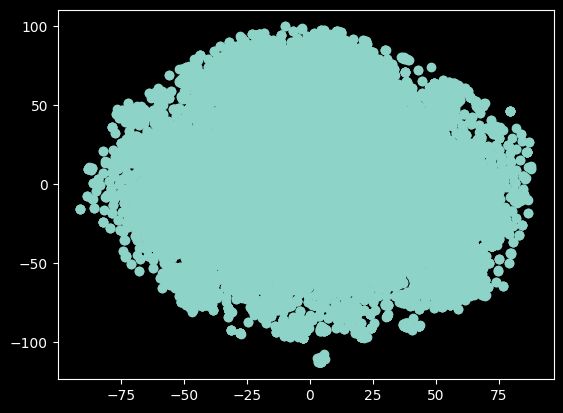

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim import matutils

sklearn_vectors = matutils.corpus2csc(tfidf_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [50]:
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim

lda_model = LdaMulticore(corpus=tfidf_corpus,
                        workers=2,
                        id2word=dictionary,
                        num_topics=10, 
                        random_state=100,
                        chunksize=50,
                        passes=10,
                        per_word_topics=True)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, tfidf_corpus, dictionary)
vis

KeyboardInterrupt: 